In [1]:
import spectra_mocking as sm
import halos
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as gf
import mass_calcs
import numpy as np
import importlib
import minima
import importlib
import numpy as np
plt.style.use('paper.mystyle')
plt.style.use('tableau-colorblind10')

In [25]:
def get_id_max_overlap(lmap_mock, lmap_true):
    """Slightly improved compared to the one used for plots of Mtomo vs Mtomo. In this case,
    the minima in the labeled map are not numbered in order, so we can miss some numbers in between.
    returns : A dictionary of the corresponding ids of overlapping structures, just returns those structures which have
    overlapping structures in true map"""
    minima_mock = np.unique(lmap_mock)
    minima_true = np.unique(lmap_true)
    minima_mock = np.delete(minima_mock, np.where(minima_mock==0))
    minima_true = np.delete(minima_true, np.where(minima_true==0))
    
    
    id_max_overlap = {'mock':np.array([]),'true':np.array([])}
    for i in minima_mock:
        indm = np.where(lmap_mock==i)
        idtrue, counts = np.unique(lmap_true[indm], return_counts=True)
        if idtrue[0] == 0:
            idtrue = np.delete(idtrue, 0)
            counts = np.delete(counts, 0)
            if counts.size== 0 :
                continue
        counts_sorted = np.sort(counts)
        # Here, If 2 sub-contours overlap identically, we pick just the one with lower id
        indt = np.where(counts == counts_sorted[-1])[0][0]
        if idtrue[indt]!=0 :
            id_max_overlap['mock'] = np.append(id_max_overlap['mock'], i)
            id_max_overlap['true'] = np.append(id_max_overlap['true'], idtrue[indt])
    id_max_overlap['true'].astype(int); id_max_overlap['mock'].astype(int)
    return id_max_overlap

def find_isolated_peaks(id_max_overlap, peaks_mock):
    
    (unique_parents, counts) = np.unique(peaks_mock['parentid'][id_max_overlap['mock']-1], return_counts=True)
    isolated_parents = unique_parents[counts==1]
    
    ind_isolated_peaks = np.where(np.isin(peaks_mock['parentid'][id_max_overlap['mock'] -1 ][:], isolated_parents))[0]
    
    return ind_isolated_peaks



def get_distance(p1, p2, L=205):
    """Calculate the distance between two points"""
    dp = np.abs(p1[:]- p2[:])
    ind = np.where(dp > L/2)
    dp[ind] = L - dp[ind]
    return dp

def compare_flux_centroid(peaks_mock,peaks_true, id_max_overlap):
    
    d = np.abs(peaks_mock['centroid'][:][id_max_overlap['mock'].astype(int)-1] - peaks_true['centroid'][:][id_max_overlap['true'].astype(int)-1])
    ind = np.where(d > 205/2)
    d[ind] = 205 - d[ind]
    return d

def get_median_dcen_profile(nmocks=20):
    
    bins = np.arange(-0.5,25,1)
    mbins = np.array([(bins[b]+bins[b+1])/2 for b in range(bins.size-1)])
    prof_perp_all, prof_rad_all, prof_perp_iso, prof_rad_iso = np.empty((nmocks, mbins.size)), np.empty((nmocks, mbins.size)), np.empty((nmocks, mbins.size)), np.empty((nmocks, mbins.size))
    for i,n in enumerate(np.arange(1,nmocks+1)):
        print(n)
        peaks_mock = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')
        peaks_true = h5py.File('./thresh/n'+str(n)+'/peaks_TNG_true_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')
        lmap_mock = h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:]
        lmap_true = h5py.File('./thresh/n'+str(n)+'/labeled_map_TNG_true_z2.4_n'+str(n)+'_sigma4_th2.35_lc2.00.hdf5','r')['map'][:]
        id_max_overlap = get_id_max_overlap(lmap_mock, lmap_true)
        ind_iso = find_isolated_peaks(id_max_overlap, peaks_mock)
        dcen = compare_flux_centroid(peaks_mock, peaks_true, id_max_overlap)
        dcen_perp = np.sqrt(dcen[:,1]**2+dcen[:,0]**2)
        pdf , _ = np.histogram(dcen_perp, bins, density=True)
        prof_perp_all[i,:] = np.cumsum(pdf)
        pdf , _ = np.histogram(dcen_perp[ind_iso], bins, density=True)
        prof_perp_iso[i,:] = np.cumsum(pdf)
        pdf , _ = np.histogram(dcen[:,2], bins, density=True)
        prof_rad_all[i,:] = np.cumsum(pdf)
        pdf , _ = np.histogram(dcen[ind_iso,2], bins, density=True)
        prof_rad_iso[i,:] = np.cumsum(pdf)        
        
    return prof_perp_all, prof_perp_iso, prof_rad_all, prof_rad_iso
        


In [28]:
prof_perp_all, prof_perp_iso, prof_rad_all, prof_rad_iso = get_median_dcen_profile()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [90]:
def plot_dcen_paper(perp_all, perp_iso, rad_all, rad_iso, bins = np.arange(-0.5,25,1)):
    
    mbins = np.array([(bins[b]+bins[b+1])/2 for b in range(bins.size-1)])
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    plt.errorbar(mbins, np.median(perp_all,axis=0), yerr=np.std(perp_all,axis=0), alpha=0.6, lw=4, elinewidth=2, capsize=7, capthick=3, label=r'$\perp$'+' all')
    plt.errorbar(mbins, np.median(perp_iso,axis=0), yerr=np.std(perp_iso,axis=0), alpha=0.6, lw=4, elinewidth=2, capsize=7, capthick=3, label=r'$\perp$'+' isolated')
    plt.errorbar(mbins, np.median(rad_all,axis=0), yerr=np.std(rad_all,axis=0), alpha=0.6, lw=4, elinewidth=2, capsize=7, capthick=3, label='|| all')
    plt.errorbar(mbins, np.median(rad_iso,axis=0), yerr=np.std(rad_iso,axis=0),  lw=4, elinewidth=2, capsize=7, capthick=3, label='|| isolated')
    """
    ax.hist(delta_d[:,2], bins=bins, label='|| all', histtype='step', ls='solid', cumulative=True, density=True, linewidth=6)
    ax.hist(delta_d[iso ,2], bins=bins, label='|| isolated', histtype='step', ls='solid', cumulative=True, density=True, linewidth=6, alpha=0.5)
    ax.hist(np.sqrt(delta_d[:,1]**2+delta_d[:,0]**2), bins=bins, label=r'$\perp$'+' all', histtype='step', ls='--', cumulative=True, density=True, linewidth=6)
    ax.hist(np.sqrt(delta_d[iso,1]**2+delta_d[iso,0]**2), bins=bins, label=r'$\perp $'+' isolated', histtype='step', ls='dashed', cumulative=True, density=True, linewidth=6)
    ax.legend(loc='lower right', fontsize=45)
    """
    ax.legend()
    ax.set_xlabel(r'$\mathrm{\Delta d_{centroid}}$')
    ax.set_ylabel('Fraction of watersheds')
    ax.grid(True, alpha=0.7)


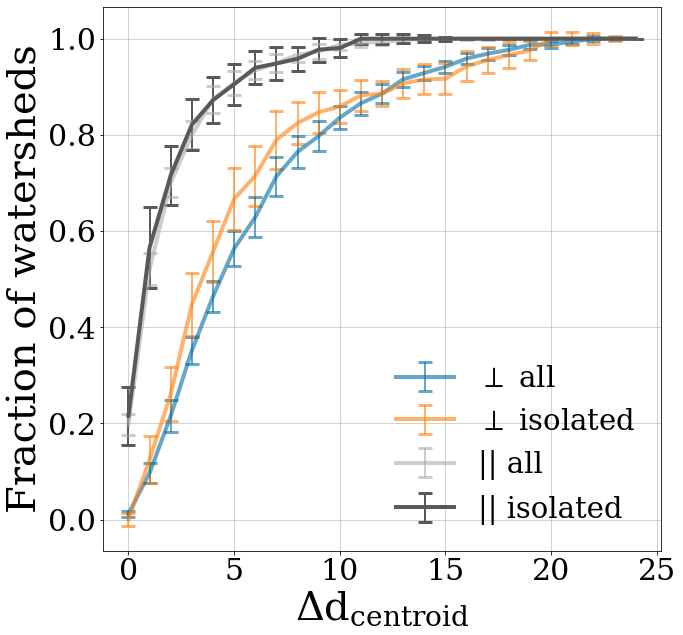

In [91]:
plot_dcen_paper(prof_perp_all, prof_perp_iso, prof_rad_all, prof_rad_iso)

In [95]:
with h5py.File('./spectra/spectra_TNG_z2.4_n1.hdf5','r') as f:
    print(f['spectra/axis'][:].size)
with h5py.File('./spectra/spectra_TNG_z2.4_n1_7832.hdf5','r') as f:
    print(f['spectra/axis'][:].size)

6739
7832


In [97]:
(7832 - 6739)/6739

0.16219023594005044